## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Долгая Любовь Васильевна

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

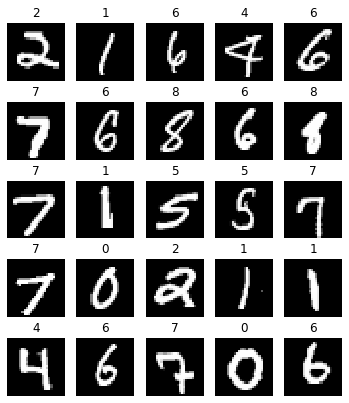

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)
    print(weight.std())

def init_layer_uni(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()

    weight.uniform_(-np.sqrt(std**2 * 12) / 2, np.sqrt(std**2 * 12) / 2)
    print(weight.flatten().std())

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 100)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer_uni(layer, 0.0, 0.1) # сюда надо подставить другие параметры

tensor(0.1001)


In [7]:
torch.zeros(100000).uniform_(0,1).std()**(2) - 1/12

tensor(4.1209e-05)

In [8]:
layers = []
sizes = [28*28] + [100]*10 + [10]
for size, next_size in zip(sizes, sizes[1:]):
    layer = nn.Linear(size, next_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    init_layer_uni(layer, 0.0, np.sqrt(2.0/(size + next_size)))
    #init_layer_uni(layer, 0.0, 0.1)

    layers.append(layer)
    #layers.append(nn.Tanh())
    layers.append(nn.Sigmoid())

module = nn.Sequential(*layers)

tensor(0.0475)
tensor(0.0998)
tensor(0.1005)
tensor(0.0994)
tensor(0.1001)
tensor(0.1007)
tensor(0.1000)
tensor(0.1003)
tensor(0.0997)
tensor(0.1000)
tensor(0.1365)


In [9]:
X = images_train.reshape(-1, 28*28)

In [10]:
res = module(X)
res.mean().backward()

forward 1.0035130977630615
forward 0.24601106345653534
forward 0.12107875198125839
forward 0.12038928270339966
forward 0.10581086575984955
forward 0.1280190348625183
forward 0.11893836408853531
forward 0.10987693816423416
forward 0.10634320229291916
forward 0.114143967628479
forward 0.11563976109027863
backward 0.0025379564613103867
backward 0.002267473377287388
backward 0.0005067643942311406
backward 0.00012729129230137914
backward 2.95243771688547e-05
backward 7.019015811238205e-06
backward 1.6187616438401164e-06
backward 3.641792716280179e-07
backward 7.623859232808172e-08
backward 1.7798789997414133e-08
backward 3.38346217709784e-09


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [11]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

In [12]:
##### YOUR CODE HERE #####
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9961597919464111
forward 1.1225155591964722
forward 1.1292396783828735
forward 1.1120342016220093
forward 1.1002079248428345
forward 1.1039296388626099
forward 1.0906978845596313
forward 1.0888582468032837
forward 1.084595799446106
forward 1.0680015087127686
backward 0.0262466911226511
backward 0.020842544734477997
backward 0.020377788692712784
backward 0.020906388759613037
backward 0.021241415292024612
backward 0.02085101045668125
backward 0.020828476175665855
backward 0.02096484787762165
backward 0.019984973594546318
backward 0.020560894161462784


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [13]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [14]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

tensor(0.0632)
tensor(0.0633)
tensor(0.0631)
tensor(0.0630)
tensor(0.0632)
tensor(0.0632)
tensor(0.0632)
tensor(0.0631)
tensor(0.0633)
tensor(0.0631)
tensor(0.0632)
tensor(0.4547)
forward 0.9961597919464111
forward 1.0340120792388916
forward 1.0075592994689941
forward 1.0214680433273315
forward 0.988419234752655
forward 0.8994643688201904
forward 0.9126841425895691
forward 0.8831440806388855
forward 0.9099498987197876
forward 0.867189884185791
forward 0.8595826625823975
forward 0.9136064648628235
backward 0.20286530256271362
backward 0.194989413022995
backward 0.18284495174884796
backward 0.1592227965593338
backward 0.15508361160755157
backward 0.13564296066761017
backward 0.11735700815916061
backward 0.09984294325113297
backward 0.09392215311527252
backward 0.08360731601715088
backward 0.07353862375020981
backward 0.059838078916072845


/home/lubov/conda/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [15]:
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./(784 + 500))))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./(500 + 500))))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./(500 + 10))))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

tensor(0.0394)
tensor(0.0448)
tensor(0.0448)
tensor(0.0448)
tensor(0.0448)
tensor(0.0447)
tensor(0.0448)
tensor(0.0448)
tensor(0.0447)
tensor(0.0448)
tensor(0.0447)
tensor(0.0617)
forward 0.9961597919464111
forward 0.6316315531730652
forward 0.43482816219329834
forward 0.3130849599838257
forward 0.22088706493377686
forward 0.15382957458496094
forward 0.1092456802725792
forward 0.07173873484134674
forward 0.05061815306544304
forward 0.036066506057977676
forward 0.025572242215275764
forward 0.018224021419882774
backward 0.02760290540754795
backward 0.003762278938665986
backward 0.0028011782560497522
backward 0.0021597370505332947
backward 0.0015530415112152696
backward 0.001076446264050901
backward 0.0007911876309663057
backward 0.0005430226447060704
backward 0.00037457747384905815
backward 0.0002809072902891785
backward 0.0001964301336556673
backward 0.00013610404857899994


<i> 1.4 Сделайте выводы по первой части </i>

Для ReLu лучше подходит инициализация He

In [16]:

def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [17]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры


class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

In [18]:
l = nn.Linear(10, 10)
list(l.parameters())

[Parameter containing:
 tensor([[-0.0543, -0.0141,  0.0385,  0.0923, -0.2022, -0.0721,  0.2508, -0.2798,
          -0.0051,  0.1403],
         [ 0.1058, -0.2610, -0.1814,  0.0205, -0.0955,  0.2298,  0.1716, -0.1938,
           0.2999, -0.2667],
         [ 0.2362, -0.2010,  0.1161, -0.0712,  0.0916,  0.0689,  0.1016, -0.1641,
           0.0126,  0.0864],
         [ 0.1855, -0.0757, -0.1622, -0.2672,  0.1899, -0.0196, -0.0381, -0.1107,
          -0.3058, -0.1390],
         [ 0.2847, -0.0459, -0.2032,  0.0282, -0.1739,  0.0549,  0.1156,  0.2995,
           0.2044, -0.1863],
         [-0.1047, -0.3154, -0.0580, -0.2007, -0.0756, -0.2961, -0.1782,  0.0510,
           0.2390, -0.1775],
         [-0.2547,  0.0242,  0.2216,  0.1348, -0.3089,  0.1929,  0.0014, -0.2756,
          -0.0907,  0.1277],
         [-0.1894,  0.0349,  0.2073, -0.1529,  0.0353, -0.2349, -0.1652,  0.1101,
           0.2505,  0.0975],
         [ 0.1728, -0.0502,  0.2942,  0.2125, -0.2914,  0.3040,  0.1913,  0.3142,
       

Epoch 9... (Train/Test) NLL: 0.126/0.135	Accuracy: 0.960/0.960


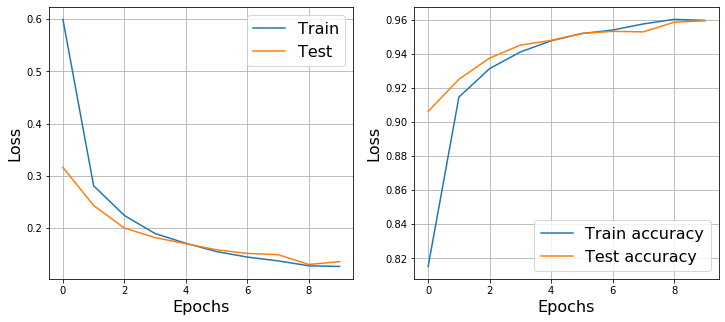

In [58]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [18]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.02))
    else:
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)

In [19]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    if next_size != 10:
        layers.append(DropConnect(size, next_size, 0.95))
        layers.append(nn.ReLU())
    else:
        layers.append(nn.Linear(size, next_size))
        layers.append(nn.LogSoftmax())

net = nn.Sequential(*layers)

In [20]:
#RAW          - 0.961
#Dropout 0.5  - 0.927
#Dropout 0.1  - 0.957
#Dropout 0.02  - 0.953
#Dropconn 0.9 - 0.962
#Dropconn 0.7 - 0.962
#Dropconn 0.95 - 0.961

Epoch 9... (Train/Test) NLL: 0.126/0.152	Accuracy: 0.961/0.956


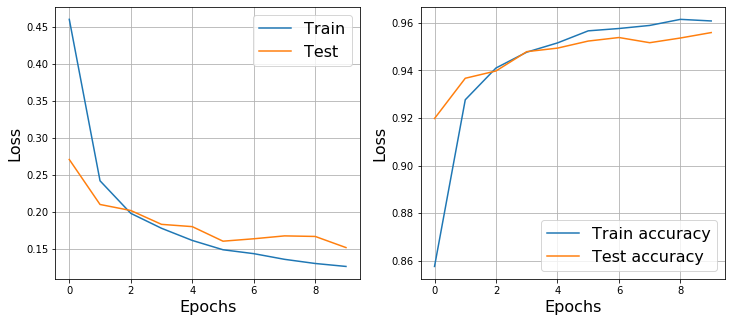

In [59]:
# from train_utils1 import train
# 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
net = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())
train(net, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.111/0.118	Accuracy: 0.966/0.963


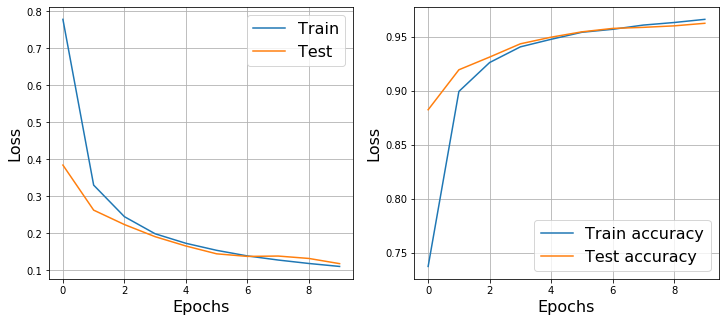

In [60]:
# from train_utils import train
# 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев 
net = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 10),
                        nn.LogSoftmax())
train(net,  10, 0.001)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

Качество с DropConnect лучше, чем с Dropout

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [40]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim, eps = 1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))
        self.eps = eps
    def forward(self, x):
        output = self.gamma*(x - x.mean(-1,keepdim = True)) / (x.std(-1,keepdim = True) + self.eps) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

### 1

Epoch 9... (Train/Test) NLL: 0.015/0.089	Accuracy: 0.995/0.975


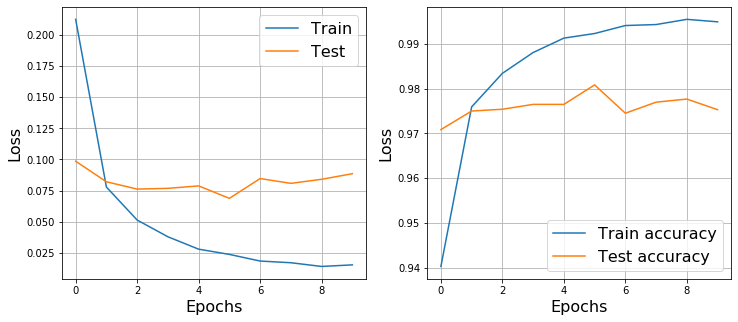

In [42]:
net = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(net, 10, 0.001)

### 2

Epoch 9... (Train/Test) NLL: 0.017/0.081	Accuracy: 0.994/0.978


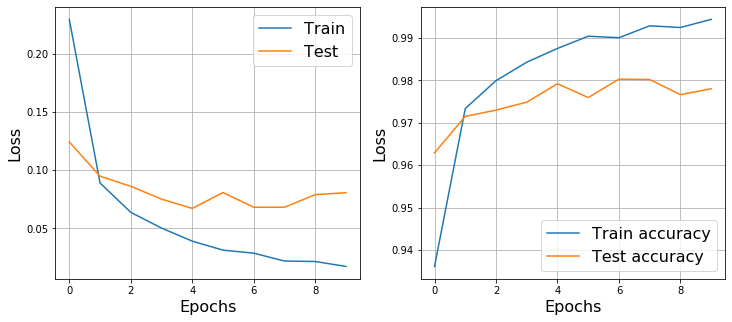

In [43]:
net = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(net, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

Layer normalization дает чуть лучший результат.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: